- buscar patron espacio temporal (personas/grupos contagiados al mismo tiempo)

- segmentar personar con sintomas: filtrar por diagnostico positivo para generar un indice de "contagiabilidad" con respecto a los contactos estrechos
*visualización 3D donde persona/grupo es un punto, y el tamaño del punto es la "contagiabilidad"

- relacionar (imputar) este dataset local (E.U) con el UMD (global)

## Datasets

## CMU

In [1]:
import pandas as pd 

cmu_state_data = pd.read_csv("data/cmu/overall-state.csv") 
cmu_state_smoothed_data = pd.read_csv("data/cmu/overall-state-smoothed.csv") 
cmu_county_data = pd.read_csv("data/cmu/overall-county.csv")

In [2]:
#cmu_state_data.head()
cmu_state_smoothed_data.head()
#cmu_county_data.head()

,date,state_code,gender,age_bucket,summed_n,smoothed_pct_cli,smoothed_pct_ili,smoothed_pct_cli_anosmia_ageusia,smoothed_pct_hh_cli,smoothed_pct_cmnty_cli,...,smoothed_pct_diabetes_weighted,smoothed_pct_cancer_weighted,smoothed_pct_heart_disease_weighted,smoothed_pct_high_blood_pressure_weighted,smoothed_pct_asthma_weighted,smoothed_pct_chronic_lung_disease_weighted,smoothed_pct_kidney_disease_weighted,smoothed_pct_autoimmune_disorder_weighted,smoothed_pct_no_above_medical_conditions_weighted,smoothed_pct_multiple_medical_conditions_weighted
0,2020-08-25,ak,female,18-34,104,0.0000,0.0000,1.0150,0.0000,20.1923,...,2.7720,0.0,2.9533,6.7597,16.0658,0.0000,0.0000,5.0479,71.3434,4.2617
1,2020-08-24,ak,female,18-34,113,0.9292,0.9292,1.8633,0.8850,20.4867,...,2.5512,0.0,2.7181,7.9151,16.5434,0.8520,0.0000,7.2427,67.7476,4.9438
2,2020-08-23,ak,female,18-34,121,0.8678,0.8678,1.7401,0.8264,21.9264,...,3.5349,0.0,2.5383,9.3086,17.6866,0.7956,0.0000,6.7638,63.8803,5.0756
3,2020-08-22,ak,female,18-34,125,0.8400,0.8400,1.6844,0.8000,20.5748,...,3.4218,0.0,2.4571,9.6981,16.5304,0.7702,0.8563,6.5474,64.9389,5.7695
4,2020-08-21,ak,female,18-34,112,0.9375,0.9375,1.8800,0.8929,20.2843,...,3.0811,0.0,0.9269,8.6103,18.6853,0.8596,0.9557,5.7656,64.4921,5.7013


In [3]:
# my select: "smoothed" - 7 day trailing average (today, and the 6 previous days)
cmu_data = cmu_state_smoothed_data

In [4]:
# percentage of missing values present
round(cmu_data.isnull().sum()/len(cmu_data)*100,2)

date                                                 0.0
state_code                                           0.0
gender                                               0.0
age_bucket                                           0.0
summed_n                                             0.0
                                                    ... 
smoothed_pct_chronic_lung_disease_weighted           0.0
smoothed_pct_kidney_disease_weighted                 0.0
smoothed_pct_autoimmune_disorder_weighted            0.0
smoothed_pct_no_above_medical_conditions_weighted    0.0
smoothed_pct_multiple_medical_conditions_weighted    0.0
Length: 103, dtype: float64

#### Dimension Columns

1. `date` - the date the data was collected (in US, Pacific time)
2. `fips` - the FIPS county ID 
3. `state_code` - the 2 letter state code
4. `gender `- gender of survey respondent. Possible values: 
	a. male
	b. female
	c. non-binary or other. This category unfortunately must be excluded from
	the data; because it is uncommonly selected, releasing aggregates for it
	could make respondents identifiable. Even if the category was not reported
	separately, its values can be deduced by comparing the other categories,
	making it possible to calculate the responses submitted by individual
	respondents who selected this option. To avoid risk of re-identification and
	harm, we remove these responses from this aggregate data.
	d. overall (aggregation of all genders)
5. `age_bucket` - age_bucket of survey respondent. Possible values:
	a. 18-34
	b. 35-54
	c. 55+
	d. overall  (aggregation of all ages)
	
6. `n` - sample size of the date, fips, gender, and age_bucket aggregation.
   **Note:** Rows with `n < 50` are not reported in this dataset.
7. `summed_n` - in smoothed datasets, summed_n is the sum of `n` over the days
   used to calculate the smoothed estimates (7 day lagging sum)
8. `weight_sums` - Sum of the weights associated with the calculations

#### date

In [5]:
from datetime import datetime

print("begin date: ", cmu_data.date.min())
print("end date: ", cmu_data.date.max())
print("dates between: ", abs((datetime.strptime(cmu_data.date.max(), "%Y-%m-%d") - 
                              datetime.strptime(cmu_data.date.min(), "%Y-%m-%d")).days))

begin date:  2020-04-12
end date:  2020-08-25
dates between:  135


In [6]:
import matplotlib.pyplot as plt

plt.plot(cmu_data['date'], cmu_data['summed_n'])
plt.show()

<Figure size 640x480 with 1 Axes>

#### state

In [7]:
cmu_data['state_code'].unique()

array(['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy'], dtype=object)

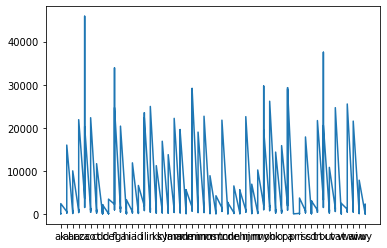

In [8]:
plt.plot(cmu_data['state_code'], cmu_data['summed_n'])
plt.show()

In [9]:
# group by: date or state_code
cmu_group_date = cmu_data.groupby(['date']).mean()
cmu_group_date.head()

,summed_n,smoothed_pct_cli,smoothed_pct_ili,smoothed_pct_cli_anosmia_ageusia,smoothed_pct_hh_cli,smoothed_pct_cmnty_cli,smoothed_pct_hh_fever,smoothed_pct_hh_sore_throat,smoothed_pct_hh_cough,smoothed_pct_hh_shortness_of_breath,...,smoothed_pct_diabetes_weighted,smoothed_pct_cancer_weighted,smoothed_pct_heart_disease_weighted,smoothed_pct_high_blood_pressure_weighted,smoothed_pct_asthma_weighted,smoothed_pct_chronic_lung_disease_weighted,smoothed_pct_kidney_disease_weighted,smoothed_pct_autoimmune_disorder_weighted,smoothed_pct_no_above_medical_conditions_weighted,smoothed_pct_multiple_medical_conditions_weighted
date,,,,,,,,,,,,,,,,,,,,,
2020-04-12,4899.057947,0.935685,0.977724,2.254113,1.382815,NaN,1.756976,9.428092,20.403786,6.655792,...,11.356118,4.905423,6.093546,29.915387,15.458257,4.785491,2.206496,6.839421,48.526276,20.472220
2020-04-13,4743.704731,0.902558,0.942097,2.205428,1.343809,NaN,1.713334,9.248018,20.116539,6.576195,...,11.257681,4.884829,6.052077,29.665601,15.510913,4.708806,2.193097,6.812597,48.670203,20.300019
2020-04-14,3978.437194,0.873196,0.907790,2.161259,1.303001,NaN,1.658248,8.920853,19.619545,6.566611,...,11.207851,4.892884,6.061745,29.530728,15.635540,4.746032,2.206199,6.869000,48.681709,20.315866
2020-04-15,3101.125612,0.855057,0.888887,2.134129,1.264448,NaN,1.614476,8.656989,19.182854,6.538047,...,11.221951,4.926848,6.063314,29.435446,15.613025,4.740890,2.211246,6.869768,48.765785,20.254654
2020-04-16,2431.464927,0.837453,0.868734,2.109723,1.245326,NaN,1.581572,8.403682,18.719375,6.417189,...,11.190882,4.882349,6.055681,29.377088,15.641229,4.722544,2.234443,6.814176,48.796846,20.204200


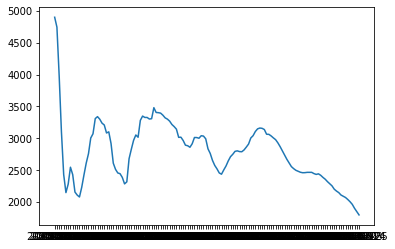

In [10]:
plt.plot(cmu_group_date['summed_n'])
plt.show()

### UMD

In [11]:
import requests
import json

# indicator: covid / flu
# type : daily / smoothed - 7 day trailing average (today, and the 6 previous days)
# country : data truncated if "all"
# daterange = 20200101-20210101

# request data from api
response = requests.get("https://covidmap.umd.edu/api/resources?indicator=covid&type=smoothed&country=Argentina&daterange=20200101-20210101").text

# convert json data to dic
jsonData = json.loads(response)
jsonData

{'data': [{'country': 'Argentina',
   'gid_0': 'ARG',
   'iso_code': 'ARG',
   'sample_size': 2543.0,
   'smoothed_cli': 0.005383,
   'smoothed_cli_se': 0.001868,
   'survey_date': '20200423'},
  {'country': 'Argentina',
   'gid_0': 'ARG',
   'iso_code': 'ARG',
   'sample_size': 5141.0,
   'smoothed_cli': 0.006113,
   'smoothed_cli_se': 0.001402,
   'survey_date': '20200424'},
  {'country': 'Argentina',
   'gid_0': 'ARG',
   'iso_code': 'ARG',
   'sample_size': 7988.0,
   'smoothed_cli': 0.006446,
   'smoothed_cli_se': 0.001118,
   'survey_date': '20200425'},
  {'country': 'Argentina',
   'gid_0': 'ARG',
   'iso_code': 'ARG',
   'sample_size': 10993.0,
   'smoothed_cli': 0.005535,
   'smoothed_cli_se': 0.000884,
   'survey_date': '20200426'},
  {'country': 'Argentina',
   'gid_0': 'ARG',
   'iso_code': 'ARG',
   'sample_size': 13794.0,
   'smoothed_cli': 0.004893,
   'smoothed_cli_se': 0.000738,
   'survey_date': '20200427'},
  {'country': 'Argentina',
   'gid_0': 'ARG',
   'iso_code':

In [12]:
umd_data = pd.DataFrame.from_dict(jsonData['data'])
umd_data.head()

,country,gid_0,iso_code,sample_size,smoothed_cli,smoothed_cli_se,survey_date
0,Argentina,ARG,ARG,2543.0,0.005383,0.001868,20200423
1,Argentina,ARG,ARG,5141.0,0.006113,0.001402,20200424
2,Argentina,ARG,ARG,7988.0,0.006446,0.001118,20200425
3,Argentina,ARG,ARG,10993.0,0.005535,0.000884,20200426
4,Argentina,ARG,ARG,13794.0,0.004893,0.000738,20200427


#### Dimension Columns

1. `country_agg` - Country of respondent
2. `GID_0` - GADM ID for Country
3. `country_region_numeric` - numeric id for country/region
4. `region_agg` - Region within country of respondent
5. `GID_1` - GADM ID for Region
6. `gender` - gender of survey respondent. Possible values: a. male b. female c. other d. overall (aggregation of all genders)
7. `age_bucket` - age_bucket of survey respondent. Possible values: a. 18-34 b. 35-54 c. 55+ d. overall (aggregation of all ages)
8. `date` - the date the data was collected (in US)
9. `total_responses` - sample size of the aggregation
10. `rolling_total_responses` - in smoothed datasets, summed_n is the sum of n over the days used to calculate the smoothed estimates (7 day lagging
sum)
11. `weight_sums` - Sum of the weights associated with the calculations

#### date

In [13]:
print("begin date: ", umd_data.survey_date.min())
print("end date: ", umd_data.survey_date.max())
print("dates between: ", abs((datetime.strptime(umd_data.survey_date.max(), "%Y%m%d") - 
                              datetime.strptime(umd_data.survey_date.min(), "%Y%m%d")).days))

begin date:  20200423
end date:  20200920
dates between:  150


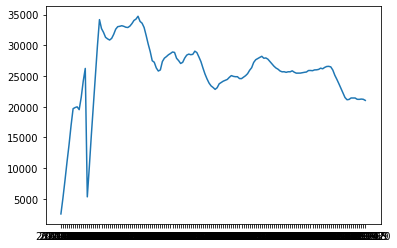

In [14]:
plt.plot(umd_data['survey_date'], umd_data['sample_size'])
plt.show()

## Signals

In [15]:
import pandas as pd
import numpy as np
%matplotlib inline

import pandas_bokeh
from ipywidgets import interact
pandas_bokeh.output_notebook()

from bokeh.plotting import figure, output_file, show

Loading BokehJS ...

### - CMU

In [16]:
def update_cmu(signals):
    cmu_group_date[signals].plot_bokeh(kind="bar", title=signals)

In [17]:
#output_file("covid_group_date.html")
#p = figure()

In [18]:
interact(update_cmu, signals=list(cmu_group_date.columns))

interactive(children=(Dropdown(description='signals', options=('summed_n', 'smoothed_pct_cli', 'smoothed_pct_i…

<function __main__.update_cmu(signals)>

### - UMD

In [19]:
def update_umd(signals):
    umd_data[signals].plot_bokeh(kind="bar", title=signals)

In [20]:
umd_signals = umd_data[["sample_size", "smoothed_cli", "smoothed_cli_se"]]

In [21]:
interact(update_umd, signals=list(umd_signals.columns))

interactive(children=(Dropdown(description='signals', options=('sample_size', 'smoothed_cli', 'smoothed_cli_se…

<function __main__.update_umd(signals)>

### time series predict models

In [22]:
cmu_group_date.columns

Index(['summed_n', 'smoothed_pct_cli', 'smoothed_pct_ili',
       'smoothed_pct_cli_anosmia_ageusia', 'smoothed_pct_hh_cli',
       'smoothed_pct_cmnty_cli', 'smoothed_pct_hh_fever',
       'smoothed_pct_hh_sore_throat', 'smoothed_pct_hh_cough',
       'smoothed_pct_hh_shortness_of_breath',
       'smoothed_pct_hh_difficulty_breathing', 'smoothed_mean_hh_cli_ct',
       'smoothed_mean_cmnty_cli_ct', 'smoothed_pct_self_fever',
       'smoothed_pct_self_cough', 'smoothed_pct_self_shortness_of_breath',
       'smoothed_pct_self_difficulty_breathing',
       'smoothed_pct_self_tiredness_or_exhaustion',
       'smoothed_pct_self_nasal_congestion', 'smoothed_pct_self_runny_nose',
       'smoothed_pct_self_muscle_joint_aches', 'smoothed_pct_self_sore_throat',
       'smoothed_pct_self_persistent_pain_pressure_in_chest',
       'smoothed_pct_self_nausea_vomiting', 'smoothed_pct_self_diarrhea',
       'smoothed_pct_self_anosmia_ageusia', 'smoothed_pct_self_other',
       'smoothed_pct_self_none

In [23]:
#data = group       
data = cmu_group_date[['smoothed_pct_hh_fever', 'smoothed_pct_hh_sore_throat', 'smoothed_pct_hh_cough',
              'smoothed_pct_hh_shortness_of_breath', 'smoothed_pct_hh_difficulty_breathing']]

#creating the train and validation set
train = data[:int(0.8*(len(data)))].dropna()
train.index = pd.to_datetime(train.index)

valid = data[int(0.8*(len(data))):].dropna()
valid.index = pd.to_datetime(valid.index)

freq=train.index.inferred_freq #'D' day

In [24]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train,freq=train.index.inferred_freq)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))
cols = data.columns

pred = pd.DataFrame(index=range(0,len(prediction)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]
        
pred.index = valid.index

/home/alexa/.local/lib/python3.6/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


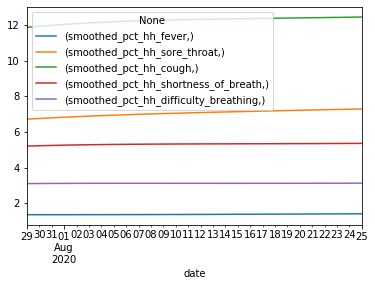

In [25]:
pred.plot()
#valid.plot()

Text(0.5, 0.98, 'test predict')

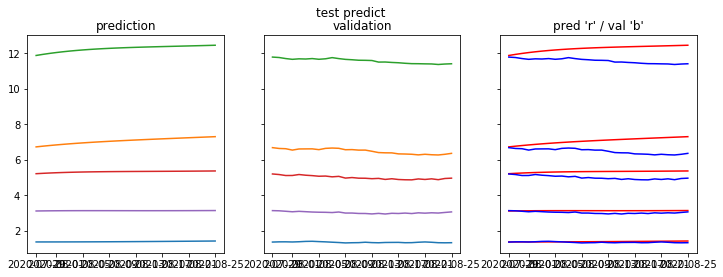

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axs[0].plot(pred)
axs[0].set_title("prediction")
axs[1].plot(valid)
axs[1].set_title("validation")
axs[2].plot(pred, 'r')
axs[2].plot(valid, 'b')
axs[2].set_title("pred 'r' / val 'b'")
fig.suptitle('test predict')

- correlacionar series de tiempo y lugares con tasa contagios oficial / regresión multimodial

- sintomas a lo largo del tiempo en un lstm: todos los sintomas entrada para predecir la tasa de contagios

#### - CMU Synthoms

In [27]:
cmu_self_synthoms = cmu_group_date[['smoothed_pct_self_cough', 
    'smoothed_pct_self_shortness_of_breath',
    'smoothed_pct_self_difficulty_breathing',
    'smoothed_pct_self_tiredness_or_exhaustion',
    'smoothed_pct_self_nasal_congestion', 
    'smoothed_pct_self_runny_nose',
    'smoothed_pct_self_muscle_joint_aches', 
    'smoothed_pct_self_sore_throat',
    'smoothed_pct_self_persistent_pain_pressure_in_chest',
    'smoothed_pct_self_nausea_vomiting', 
    'smoothed_pct_self_diarrhea',
    'smoothed_pct_self_anosmia_ageusia',                   
    'smoothed_pct_self_other',
    'smoothed_pct_self_multiple_symptoms',
    'smoothed_pct_tested_and_positive',
    'smoothed_pct_contact_covid_positive',
    'smoothed_pct_tested_and_negative',
    'smoothed_pct_tested_no_result'
]]

In [28]:
# tested negative + tested no result
cmu_self_synthoms['new_total_tested_positive_negative_noresult'] = cmu_self_synthoms[["smoothed_pct_tested_and_positive",
                                                                                      "smoothed_pct_tested_and_negative",
                                                                                      "smoothed_pct_tested_no_result"]].sum(axis=1)

/home/alexa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
# normalize positive = positive / total
cmu_self_synthoms['new_normalize_tested_positive'] = cmu_self_synthoms["smoothed_pct_tested_and_positive"] / cmu_self_synthoms['new_total_tested_positive_negative_noresult'] 

cmu_self_synthoms.head()

/home/alexa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,smoothed_pct_self_cough,smoothed_pct_self_shortness_of_breath,smoothed_pct_self_difficulty_breathing,smoothed_pct_self_tiredness_or_exhaustion,smoothed_pct_self_nasal_congestion,smoothed_pct_self_runny_nose,smoothed_pct_self_muscle_joint_aches,smoothed_pct_self_sore_throat,smoothed_pct_self_persistent_pain_pressure_in_chest,smoothed_pct_self_nausea_vomiting,smoothed_pct_self_diarrhea,smoothed_pct_self_anosmia_ageusia,smoothed_pct_self_other,smoothed_pct_self_multiple_symptoms,smoothed_pct_tested_and_positive,smoothed_pct_contact_covid_positive,smoothed_pct_tested_and_negative,smoothed_pct_tested_no_result,new_total_tested_positive_negative_noresult,new_normalize_tested_positive
date,,,,,,,,,,,,,,,,,,,,
2020-04-12,16.718011,5.239402,2.549046,15.271851,17.969644,17.089697,11.646393,8.042446,2.811637,2.978713,6.752863,1.595244,3.867819,28.093638,0.377584,1.127913,2.147876,0.724539,3.249999,0.116180
2020-04-13,16.481318,5.170328,2.531063,15.230762,17.812147,16.942977,11.550426,7.902430,2.752686,2.956105,6.668440,1.571158,3.836065,27.859154,0.395428,1.143282,2.224845,0.704958,3.325231,0.118917
2020-04-14,16.115893,5.159151,2.567473,15.253278,17.542579,16.775354,11.637088,7.608151,2.695708,2.968315,6.573607,1.561309,3.766855,27.507669,0.429281,1.180226,2.384108,0.683966,3.497355,0.122745
2020-04-15,15.704991,5.109388,2.568721,15.239619,17.282287,16.764089,11.703762,7.380353,2.615952,2.980110,6.585546,1.549343,3.734145,27.213993,0.444278,1.217140,2.538490,0.641482,3.624250,0.122585
2020-04-16,15.259887,5.019249,2.545467,15.376799,17.304209,16.704256,11.726163,7.191357,2.607128,3.000713,6.609602,1.547228,3.690226,27.081182,0.460616,1.239429,2.718260,0.622438,3.801313,0.121173


In [30]:
synthoms = list(cmu_self_synthoms.columns)
synthoms

['smoothed_pct_self_cough',
 'smoothed_pct_self_shortness_of_breath',
 'smoothed_pct_self_difficulty_breathing',
 'smoothed_pct_self_tiredness_or_exhaustion',
 'smoothed_pct_self_nasal_congestion',
 'smoothed_pct_self_runny_nose',
 'smoothed_pct_self_muscle_joint_aches',
 'smoothed_pct_self_sore_throat',
 'smoothed_pct_self_persistent_pain_pressure_in_chest',
 'smoothed_pct_self_nausea_vomiting',
 'smoothed_pct_self_diarrhea',
 'smoothed_pct_self_anosmia_ageusia',
 'smoothed_pct_self_other',
 'smoothed_pct_self_multiple_symptoms',
 'smoothed_pct_tested_and_positive',
 'smoothed_pct_contact_covid_positive',
 'smoothed_pct_tested_and_negative',
 'smoothed_pct_tested_no_result',
 'new_total_tested_positive_negative_noresult',
 'new_normalize_tested_positive']

In [31]:
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "darkblue",
    "orangered",
    "black",
    "black",
    "blue",
    "blue",
    "black",
    "black",
    "blue",
    "red"
]

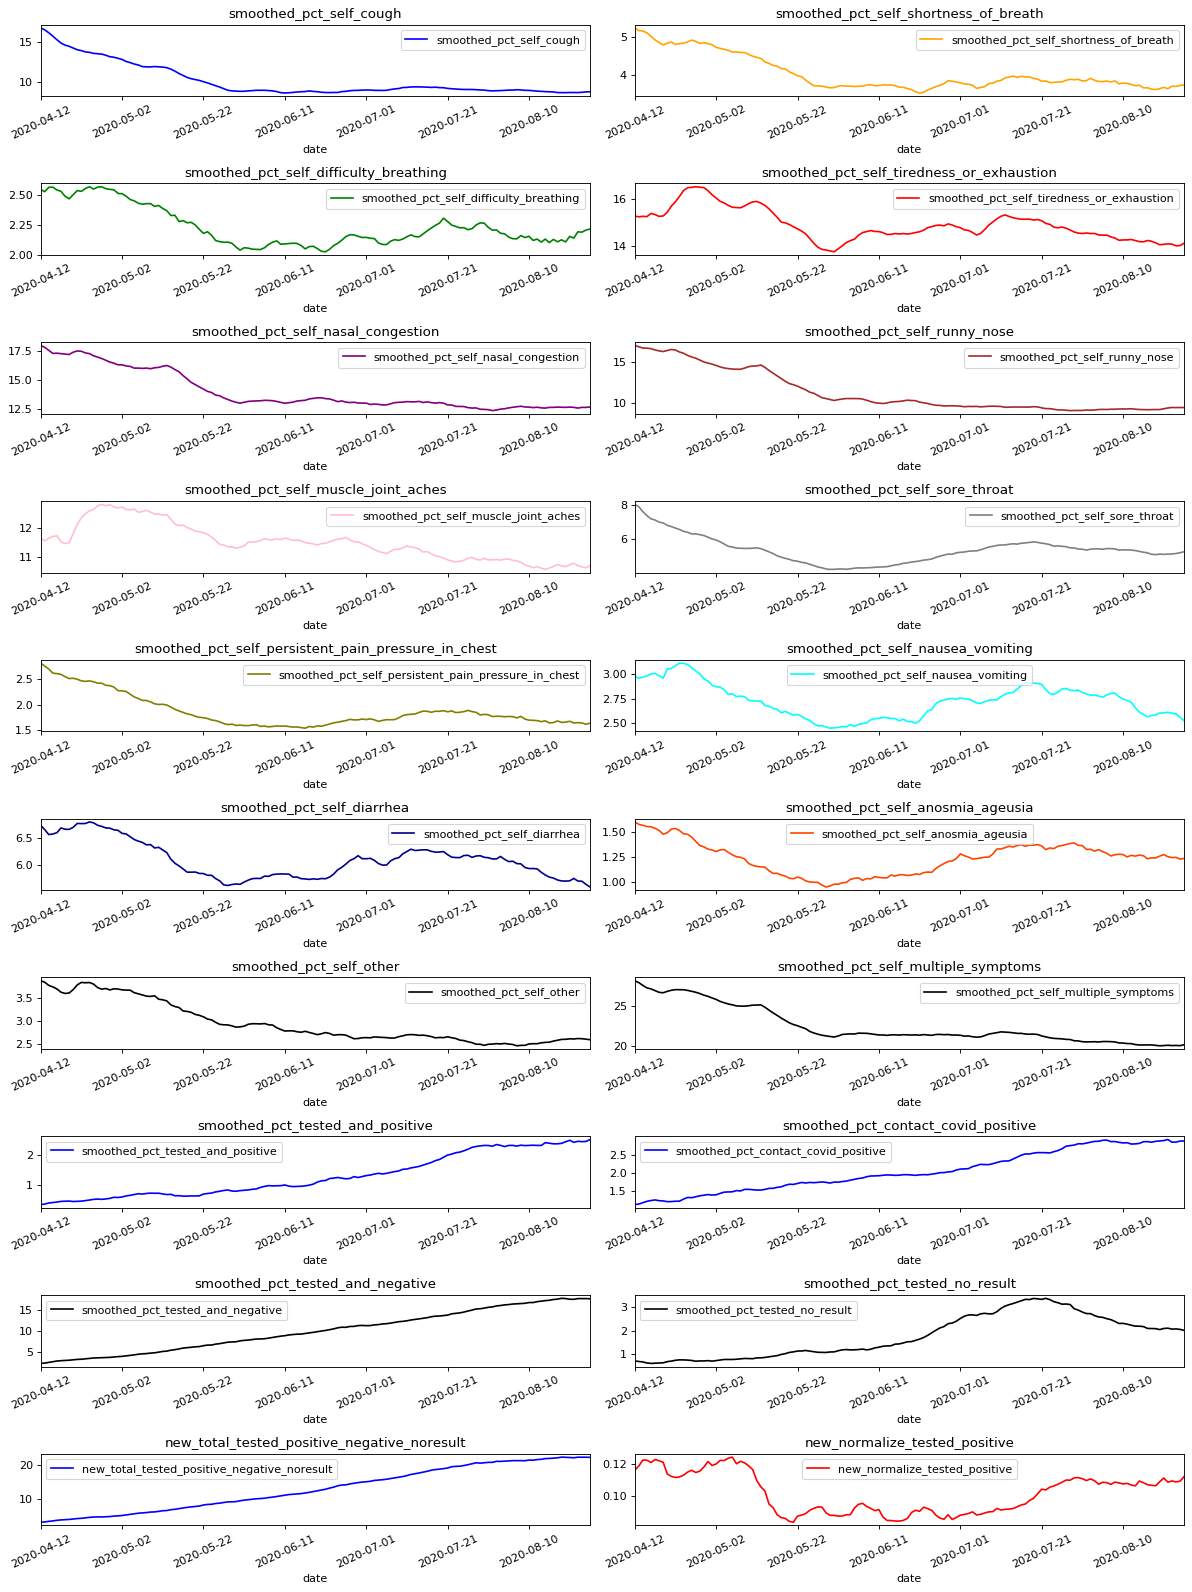

In [32]:
def synthoms_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=10, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(synthoms)):
        key = synthoms[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(synthoms[i]),
            rot=25,
        )
        ax.legend([synthoms[i]])
    plt.tight_layout()


synthoms_visualization(cmu_self_synthoms)

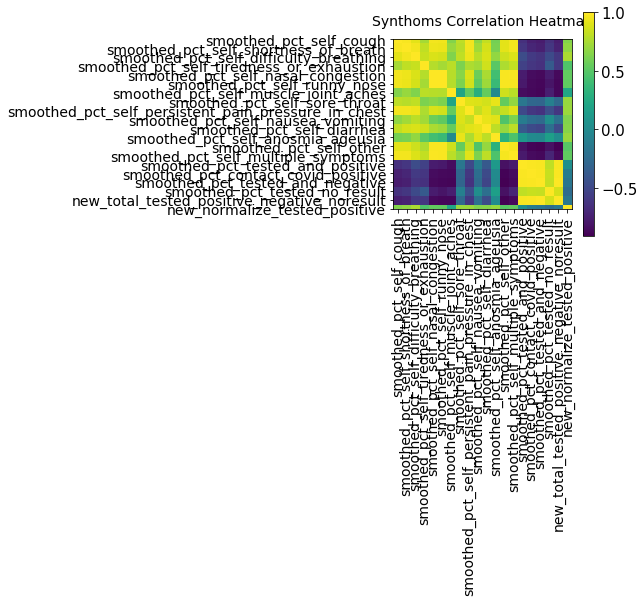

In [33]:
def synthoms_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    plt.title("Synthoms Correlation Heatmap", fontsize=14)
    plt.show()


synthoms_heatmap(cmu_self_synthoms)

In [34]:
import tensorflow as tf
from tensorflow import keras

#### Data Preprocessing

In [35]:
synthoms.remove('smoothed_pct_self_other')
synthoms.remove('smoothed_pct_self_multiple_symptoms')
synthoms.remove('smoothed_pct_tested_and_positive')
synthoms.remove('smoothed_pct_contact_covid_positive')
synthoms.remove('smoothed_pct_tested_and_negative')
synthoms.remove('smoothed_pct_tested_no_result')
synthoms.remove('new_total_tested_positive_negative_noresult') 
synthoms

['smoothed_pct_self_cough',
 'smoothed_pct_self_shortness_of_breath',
 'smoothed_pct_self_difficulty_breathing',
 'smoothed_pct_self_tiredness_or_exhaustion',
 'smoothed_pct_self_nasal_congestion',
 'smoothed_pct_self_runny_nose',
 'smoothed_pct_self_muscle_joint_aches',
 'smoothed_pct_self_sore_throat',
 'smoothed_pct_self_persistent_pain_pressure_in_chest',
 'smoothed_pct_self_nausea_vomiting',
 'smoothed_pct_self_diarrhea',
 'smoothed_pct_self_anosmia_ageusia',
 'new_normalize_tested_positive']

In [36]:
cmu_self_synthoms = cmu_self_synthoms.drop(['smoothed_pct_self_other',
                                            'smoothed_pct_self_multiple_symptoms',
                                            'smoothed_pct_tested_and_positive',
                                            'smoothed_pct_contact_covid_positive',
                                            'smoothed_pct_tested_and_negative',
                                            'smoothed_pct_tested_no_result',
                                            'new_total_tested_positive_negative_noresult'], axis=1)

cmu_self_synthoms.columns

Index(['smoothed_pct_self_cough', 'smoothed_pct_self_shortness_of_breath',
       'smoothed_pct_self_difficulty_breathing',
       'smoothed_pct_self_tiredness_or_exhaustion',
       'smoothed_pct_self_nasal_congestion', 'smoothed_pct_self_runny_nose',
       'smoothed_pct_self_muscle_joint_aches', 'smoothed_pct_self_sore_throat',
       'smoothed_pct_self_persistent_pain_pressure_in_chest',
       'smoothed_pct_self_nausea_vomiting', 'smoothed_pct_self_diarrhea',
       'smoothed_pct_self_anosmia_ageusia', 'new_normalize_tested_positive'],
      dtype='object')

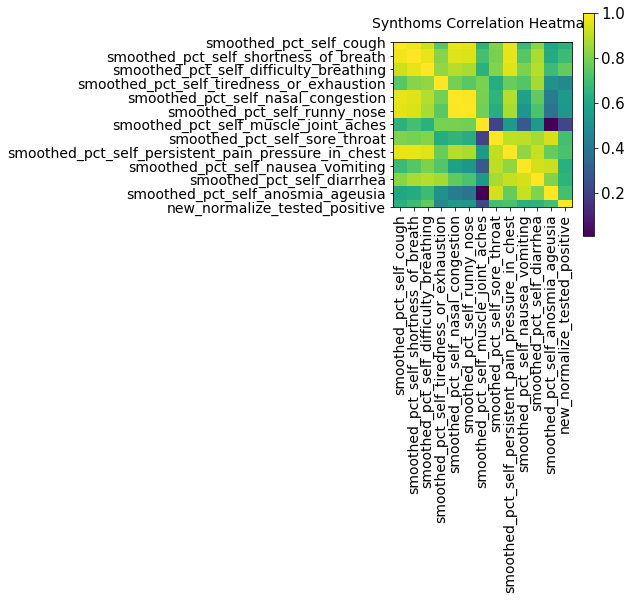

In [37]:
synthoms_heatmap(cmu_self_synthoms)

In [38]:
selected_features = [synthoms[i] for i in range(0, len(synthoms))]
features = cmu_self_synthoms[selected_features]
features.index = cmu_self_synthoms.index

print(features.shape)
features.head()

(136, 13)


,smoothed_pct_self_cough,smoothed_pct_self_shortness_of_breath,smoothed_pct_self_difficulty_breathing,smoothed_pct_self_tiredness_or_exhaustion,smoothed_pct_self_nasal_congestion,smoothed_pct_self_runny_nose,smoothed_pct_self_muscle_joint_aches,smoothed_pct_self_sore_throat,smoothed_pct_self_persistent_pain_pressure_in_chest,smoothed_pct_self_nausea_vomiting,smoothed_pct_self_diarrhea,smoothed_pct_self_anosmia_ageusia,new_normalize_tested_positive
date,,,,,,,,,,,,,
2020-04-12,16.718011,5.239402,2.549046,15.271851,17.969644,17.089697,11.646393,8.042446,2.811637,2.978713,6.752863,1.595244,0.116180
2020-04-13,16.481318,5.170328,2.531063,15.230762,17.812147,16.942977,11.550426,7.902430,2.752686,2.956105,6.668440,1.571158,0.118917
2020-04-14,16.115893,5.159151,2.567473,15.253278,17.542579,16.775354,11.637088,7.608151,2.695708,2.968315,6.573607,1.561309,0.122745
2020-04-15,15.704991,5.109388,2.568721,15.239619,17.282287,16.764089,11.703762,7.380353,2.615952,2.980110,6.585546,1.549343,0.122585
2020-04-16,15.259887,5.019249,2.545467,15.376799,17.304209,16.704256,11.726163,7.191357,2.607128,3.000713,6.609602,1.547228,0.121173


In [39]:
split_fraction = 0.8
train_split = int(split_fraction * int(cmu_self_synthoms.shape[0]))
print("train split = ", train_split)

train split =  108


In [40]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    #data_mean = data[:train_split].mean(axis=0)
    #data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [41]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features) 
features

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.883314,2.346348,1.665076,0.366043,2.105651,2.001798,-0.088708,3.048303,2.715625,1.332423,1.717331,2.127645,1.237321
1,2.772962,2.202509,1.564111,0.302821,2.014067,1.945633,-0.265485,2.888029,2.539238,1.208986,1.481295,1.989343,1.438623
2,2.602591,2.179233,1.768535,0.337466,1.857316,1.881466,-0.105847,2.551174,2.368755,1.275651,1.216154,1.932796,1.720033
3,2.411018,2.075606,1.775544,0.316449,1.705958,1.877154,0.016971,2.290417,2.130119,1.340053,1.249534,1.864086,1.708279
4,2.203500,1.887902,1.644981,0.527522,1.718705,1.854250,0.058235,2.074078,2.103716,1.452541,1.316793,1.851943,1.604465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-0.834056,-0.960137,-0.625586,-1.458395,-1.013240,-0.944402,-1.686038,-0.296644,-0.779875,-0.663669,-1.122974,0.149054,0.684420
132,-0.836797,-0.824762,-0.331178,-1.473144,-1.049544,-0.922161,-1.842008,-0.288056,-0.762613,-0.725154,-1.262313,0.099493,0.735062
133,-0.820008,-0.835003,-0.345024,-1.582585,-1.012825,-0.926935,-1.917710,-0.258384,-0.777164,-0.750589,-1.274066,0.112742,0.695342
134,-0.795780,-0.778364,-0.246963,-1.568216,-1.015517,-0.922690,-1.978245,-0.206160,-0.854204,-0.954721,-1.441669,0.014289,0.726282


In [42]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

print("train_data shape: ", train_data.shape)
print("val_data shape: ", val_data.shape)

train_data shape:  (108, 13)
val_data shape:  (28, 13)


#### Training dataset

In [43]:
# synthoms up to anosmia_ageusia (11)
x_train = train_data[[i for i in range(11)]].values

# y is new_normalize_tested_positive (12)
y_train = features.iloc[0 : train_split][[12]]

print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (108, 11)
y_train (108, 1)


In [44]:
learning_rate = 0.001
epochs = 250
sequence_length = 14 # 14 days

In [45]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    #sampling_rate=step, #1
    #batch_size=batch_size #128
)

In [46]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (95, 14, 11)
Target shape: (95, 1)


#### Validation dataset

In [47]:
x_val = val_data[[i for i in range(11)]].values
y_val = features.iloc[train_split:][[12]]

print("x_val", x_val.shape)
print("y_val", y_val.shape)

x_val (28, 11)
y_val (28, 1)


In [48]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    #sampling_rate=step,
    #batch_size=batch_size,
)

In [49]:
for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (15, 14, 11)
Target shape: (15, 1)


#### training model

In [50]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 11)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5632      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


In [51]:
path_checkpoint = "synthoms_model.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5) #5

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [52]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/250
1/1 [==============================] - ETA: 0s - loss: 0.9118
Epoch 00001: val_loss improved from inf to 1.29682, saving model to synthoms_model.h5
1/1 [==============================] - 1s 1s/step - loss: 0.9118 - val_loss: 1.2968
Epoch 2/250
1/1 [==============================] - ETA: 0s - loss: 0.8378
Epoch 00002: val_loss did not improve from 1.29682
1/1 [==============================] - 0s 54ms/step - loss: 0.8378 - val_loss: 1.3868
Epoch 3/250
1/1 [==============================] - ETA: 0s - loss: 0.7693
Epoch 00003: val_loss did not improve from 1.29682
1/1 [==============================] - 0s 54ms/step - loss: 0.7693 - val_loss: 1.4769
Epoch 4/250
1/1 [==============================] - ETA: 0s - loss: 0.7059
Epoch 00004: val_loss did not improve from 1.29682
1/1 [==============================] - 0s 53ms/step - loss: 0.7059 - val_loss: 1.5665
Epoch 5/250
1/1 [==============================] - ETA: 0s - loss: 0.6474
Epoch 00005: val_loss did not improve from 1.2968

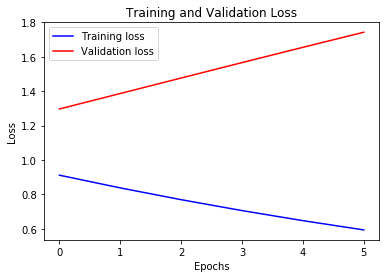

In [53]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [54]:
for x, y in dataset_val.take(12):
    print("x ", x)
    print("y ", y) 
    

x  tf.Tensor(
[[[-0.68592146 -0.4721346   0.09418428 ... -0.3117043   0.52868691
    0.08929524]
  [-0.69456934 -0.45004458  0.07682785 ... -0.27760235  0.55654329
    0.00314298]
  [-0.72325504 -0.53991322 -0.12185804 ... -0.29812346  0.42619827
   -0.01844984]
  ...
  [-0.70661018 -0.69379215 -0.59849643 ... -0.55262498  0.1849746
   -0.54018195]
  [-0.71064251 -0.6529905  -0.54029103 ... -0.61736556  0.06098272
   -0.59633042]
  [-0.7293834  -0.66821408 -0.73345026 ... -0.6244958  -0.01424603
   -0.59536487]]

 [[-0.69456934 -0.45004458  0.07682785 ... -0.27760235  0.55654329
    0.00314298]
  [-0.72325504 -0.53991322 -0.12185804 ... -0.29812346  0.42619827
   -0.01844984]
  [-0.73953913 -0.52100121 -0.25123224 ... -0.40567056  0.33798265
   -0.0841334 ]
  ...
  [-0.71064251 -0.6529905  -0.54029103 ... -0.61736556  0.06098272
   -0.59633042]
  [-0.7293834  -0.66821408 -0.73345026 ... -0.6244958  -0.01424603
   -0.59536487]
  [-0.75511091 -0.72855398 -0.67269387 ... -0.64436655 -0.10

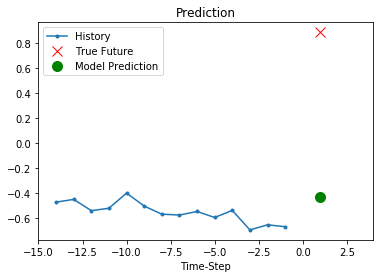

In [55]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0] - 1, (future + 1) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Prediction",
    )